---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<br>
<br>

# Overview

In this section, I leverage several different supervised machine learning techniques to run predictions on three different target variables. As a refresher, supervised machine learning is a suite of algorithms that are trained labeled datasets to classify or predict outcomes for specific target variables[@IBMsupervised]. In this section, I use three subcategories of supervised learning methods, including regression, binary classification, and multi-class classification. For training, I take advantage of `scikit-learn`'s train_test_split object to break up my data into a training and testing set. After running each model, I will look at each model's respective error metrics to gauge their performance in prediction/classification tasks. 

Before beginning the modeling process, I carry out feature extraction on our text data. For this, I leverage the TF-IDF embedding method that has been used in multiple parts of this study. From there, I build out two custom modeling pipelines for classification and regression models. The piplines will be modular, allowing us to control which feature are used in the modeling process. Each of the pipelines will apply a set of specific methods for their given goal, compare each result and output the highest performing model's metrics.

At the end of this section I will present my findings, including a summary of each model's performance, and some visualizations to supplement said fidings.

# Section 1: Setup

**Importing Data and Packages**

**Data Preprocessing**

**Feature Extraction**


## Importing Data and Packages

Let's begin our process by importing relevant packages

In [23]:
# Data loading and manipulation packages
import gzip
import pandas as pd
import numpy as np

# Data preprocessing and feature extraction packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Model training packages
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Model evaluation packages
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_curve,
    auc
)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Ignoring warnings 
import warnings 
warnings.filterwarnings("ignore")

Now, we can load in our data:

In [2]:
# Pathway to raw data
data_path = "../../data/processed-data/reviews_short.csv.gz"

# Unzip the CSV file
with gzip.open(data_path, 'rb') as f:
    # Read the CSV file into a dataframe
    reviews = pd.read_csv(f)

reviews.head(1)

,reviewRating,vote,verified,reviewTime,reviewerID,productID,reviewerName,reviewText,summary,reviewTextClean,summaryClean,binary_target
0,5.0,2,False,2016-06-17,A7HY1CEDK0204,B00I9GYG8O,Jor El,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,youre looking cinema k capabilities budget cam...,filmmakers love camera,positive


In [3]:
#| echo: false
reviews['reviewTextClean'] = reviews['reviewTextClean'].astype(str)
reviews['reviewRating'] = reviews['reviewRating'].astype(int)

## Data Preprocessing

### Handling Zero-Vote rows

To start out this process, I shift my focus to the heavily-skewed 'vote' column, where a vast majority of rows have zero votes. In order to reconcile this, while making the `vote` column still usable in our models, I will convert it into a binary-encoded column called `vote_binary` where its values are $1$ if the value for `vote` is non-zero, and $0$ otherwise

In [4]:
# Checking % of zero-vote rows
print(f"Percent of reviews with 0 votes: {round((len(reviews.loc[reviews['vote'] == 0])/len(reviews)*100), 2)}%")

Percent of reviews with 0 votes: 86.02%


In [5]:
# Creating vote_binary column
reviews['vote_binary'] = (reviews['vote'] > 0).astype(int)
# Printing result
reviews[['vote', 'vote_binary']].head()

,vote,vote_binary
0,2,1
1,0,0
2,0,0
3,0,0
4,5,1


### Encoding `verified` Column

Next, let's do the same thing for `verified`, setting "True" to 1, and "False" to 0.

In [6]:
# Creating verified_binary column
reviews['verified_binary'] = (reviews['verified'] == True).astype(int)
# Printing result
reviews[['verified', 'verified_binary']].head()

,verified,verified_binary
0,False,0
1,False,0
2,True,1
3,True,1
4,True,1


### Encoding `productID`

Here, I use sklearn's [`LabelEncoder`](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html) object to convert the productID column into a more useful format for modeling. For this process, I will keep both the non-encoded and encoded version of `productID`, as the non-encoded version may be useful for tree-based algorithms like Random Forests and Gradient Boosting, while the encoded version may prove more useful in models that require a numerical input, like Logistic Regression and Support Vector Machines SVM.

In [7]:
# Initializing LabelEncoder object
encoder = LabelEncoder()
# Fitting to our productID column
reviews['productID_encoded'] = encoder.fit_transform(reviews['productID'])
# Checking result
reviews[['productID', 'productID_encoded']].head()

,productID,productID_encoded
0,B00I9GYG8O,27766
1,B01DB6BK5I,42622
2,B00011KM3I,1415
3,B000EDOSFQ,3153
4,B01CVOLKKQ,42382


### Encoding Binary Target

Here, I use binary encoding to create a new `binary_sentiment` column that adjusts values in the `binary_target` column. Specifically, I will change the value "positive" to 1, and "negative" to 0.

In [8]:
# Creating verified_binary column
reviews['binary_sentiment'] = (reviews['binary_target'] == "positive").astype(int)
# Printing result
reviews[['binary_target', 'binary_sentiment']].head()

,binary_target,binary_sentiment
0,positive,1
1,negative,0
2,positive,1
3,positive,1
4,negative,0


### Dropping Unnecessary Columns

With that out of the way, let's begin to drop unnecessary columns. For this section, we will drop:

- `binary_sentiment:` String-encoded sentiment column
- `vote:` Non-encoded vote column
- `productID:` Non-encoded product ID
- `verified:` Non-encoded values for varified column
- `reviewTime:` Time of review, since we are not conducting any time series analysis here
- `reviewerID:` ID of reviewer
- `reviewerName:` Name of reviewer

I choose to leave in the uncleaned versions of the review text and summary in case I want to use some all-in-one embedding tools down the line like `BERT`.


In [9]:
# Setting columns to drop 
cols_to_drop = ['binary_target', 'verified', 'vote','productID', 'reviewTime', 'reviewerID', 'reviewerName']
# Dropping
reviews = reviews.drop(columns=cols_to_drop)
# Printing result
reviews.head(1)

,reviewRating,reviewText,summary,reviewTextClean,summaryClean,vote_binary,verified_binary,productID_encoded,binary_sentiment
0,5,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,youre looking cinema k capabilities budget cam...,filmmakers love camera,1,0,27766,1


### Renaming and Reordering Columns for Cleanliness

In [10]:
# Renaming columns 
renamed_columns = {
    'reviewRating': 'rating',
    'reviewText': 'text',
    'summary': 'summary',
    'reviewTextClean': 'text_clean',
    'summaryClean': 'summary_clean',
    'binary_sentiment': 'sentiment',
    'vote_binary': 'vote',
    'verified_binary': 'verified',
    'productID_encoded': 'product_id'
}

reviews = reviews.rename(columns=renamed_columns)

# Rordering columns for clarity
column_order = [
    'product_id',
    'rating',
    'vote',
    'verified',
    'sentiment',
    'text_clean', 
    'summary_clean', 
    'text', 
    'summary', 
]

reviews = reviews[column_order]

# Printing result
reviews.head(1)

,product_id,rating,vote,verified,sentiment,text_clean,summary_clean,text,summary
0,27766,5,1,0,1,youre looking cinema k capabilities budget cam...,filmmakers love camera,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.


As a reminder for our boolean columns:

- `vote`: $(1 \ \text{for non-zero vote counts}, \ 0 \  \text{otherwise})$
- `verified`: $(1 \ \text{if account is verified}, \ 0 \  \text{otherwise})$
- `sentiment`: $(1 \ \text{if rating} \ \geq{4}, \ 0 \  \text{if rating} \ < 4)$

## Feature Extraction

### Polarity

Before moving on to more advanced feature extraction, I am going to quickly add back the `polarity` column that we worked with in the EDA section to serve as a target variable in our regression models. If you need a refresher on polarity, please head over to the [EDA](../eda/main.ipynb) section where I provide an overview.

In [11]:
# TextBlob allows us to feed raw text into it for polarity extraction, so I will do that here
reviews['polarity'] = reviews['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# printing result
reviews[['text', 'rating', 'polarity']].head(1)

,text,rating,polarity
0,If you're looking for Cinema 4K capabilities o...,5,0.321675


### TF-IDF

Term frequency-inverse document freqeuncy (TF-IDF) is a process that measures the importance of a word (or pair of words in our case) by comparing its rate of appearance in a document to its rate of appearance in a whole collection of documents. In this approach, the weight of a given word or word-pair depends both on its frequency and rarity. The benefit of TF-IDF over a simple document term matrix is that TF-IDF will punish words/pairs that occur frequently across our corpus, and favor words that have importance in their respective documents, and are found less frequently across the corpus[@TFIDF]. Recall the formulaic representation of TF-IDF that I include on the home page:

In equation form[@TFIDF]: 
$$
\text{TF}(t,d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$
$$
\text{IDF}(t,D) = log_{e}\frac{\text{Total number of documents D in corpus}}{\text{Number of documents containing term t}}
$$
$$
\text{TF-IDF} = TF(t,d) \cdot IDF(t,D)
$$


For its implementation here, I define the function `tfidf_embedding()` that takes in our pandas dataframe, applies TF-IDF to the cleaned review text column, and returns a dataframe that contains all of the tfidf features. The main function process uses the `TfidfVectorizer` from the sklearn library. In my implementation, I feed in the following parameters[@scikitTFIDF]:

- `max_features`: Threshold for the number of features to be ranked by their term frequency across the corpus.
- `ngram_range`: A tuple that controls the range of n-values for different n-grams to be extracted. In my case, I use (1,2) to include both unigrams and bigrams.

In [12]:
def tfidf_embedding(df, text_column, max_features=1000, ngram_range=(1,2)):
    """
    This function:
    1) Takes in a pandas dataframe and target text column
    2) Applies TF-IDF embedding using the set parameters
    3) Returns pandas dataframe with tf-idf features 
    """

    # Initialize TfidfVectorizer
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english') # Included stopwords param here to help clean up spots that I may have missed in text processing section

    # Fit tfidf to our target column
    tfidf_features = tfidf.fit_transform(df[text_column])

    # Create pandas dataframe for tfidf features
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_features.shape[1])])

    # Concatenate TF-IDF features df with our original df to maintain other features
    df_tfidf = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis = 1)

    return df_tfidf

In [13]:
## Applying this function to our reviews data set
reviews_tfidf = tfidf_embedding(reviews, text_column='text_clean', max_features=500, ngram_range=(1,2))
# Printing shape
reviews_tfidf.shape

(100000, 510)

In [14]:
reviews_tfidf.head(1)

,product_id,rating,vote,verified,sentiment,text_clean,summary_clean,text,summary,polarity,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,27766,5,1,0,1,youre looking cinema k capabilities budget cam...,filmmakers love camera,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,0.321675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219799,0.0


# Section 2: Classification

**Model Selection**

**Modeling Pipline**

**Binary Classification**

**Multi-class Classification**

**Undersampling**


## Model Selection

### Binary Classification
***Predicting sentiment value (positive or negative)***

#### Logistic Regression

- **Overview**

Logistic regression is a type of supervised learning technique that is often used to predict a binary outcome (A or B). The model does this by taking in a set of independent variables for a given observation, and calculating the probability that they belong to a certain target class. Logistic regressions use a [sigmoid function](https://www.linkedin.com/pulse/understanding-sigmoid-function-logistic-regression-piduguralla/) that maps the linear combination of inputs to a final probability in the range [0, 1].[@sigmoid] If the value returned by the sigmoid function is $\geq 0.5$, then the model assigns the observation to the target class (in our case it assigns the value $1$ to reviews that it believes are positive)

**Sigmoid Function:**
<br>
![](../../xtra/multiclass-portfolio-website/images/sigmoid.png){width="500px"}
<br>
Source: [Daily Dose of Data Science](https://www.dailydoseofds.com/why-do-we-use-sigmoid-in-logistic-regression/)
<br>

- **Model Rationale**

When selecting which binary classification models I wanted to use for predicting `sentiment`, logistic regression stood out as an obvious baseline. The model's simplicity, and direct probabilistic output makes it a reliable and lightweight option for running predictions using TF-IDF embeddings. 

#### Random Forest 

- **Overview**

Random forests are a [decision tree](https://en.wikipedia.org/wiki/Decision_tree) based approach to machine learning. Decision trees are non-parametric models that can be used for both regression and classification. Their process begins by selecting a "root node", or initial question about a feature in the data. From there they break off into different branches that ask more and more specific questions about the features. The end result, also called the "leaf node," outputs the class that best fits the criteria defined in the upper nodes.[@decisiontrees] Random forest models take this same approach, but instead of relying on a single tree, they build multiple decision trees during the training process, and aggregate their results to provide stronger prediction. 

**Decision Tree vs. Random Forest:**
<br>
![](../../xtra/multiclass-portfolio-website/images/trees_v_forests.jpg){width="500px"}
<br>
Source: [Towards Data Science](https://towardsdatascience.com/10-decision-trees-are-better-than-1-719406680564)
<br>

- **Model Rationale**

When brainstorming which models I wanted to use for binary classification, Random Forests stood out as a solid candidate for their ability to handle high dimensional data (like we see with our TF-IDF embeddings). Random Forests also come with the added benefit of being robust to potentially overfitting the data - as their ensemble structure requires different individual trees to be trained on subsets of the data.


### Multi-class Classification
***Predicting review rating (1-5)***

#### Support Vector Machine (SVM)

- **Overview**

Support Vector Machines (SVMs) are supervised learning techniques that are commonly applied to classification problems. They assign classes by finding the optimal "hyperplane" in a high dimensional space that maximizes the distance between groups of data points.[@SVM] In simple english, SVMs are looking for the best line of boundary that creates the largest distance between groups of points, and then assigns the different groups to their own class.

**SVM Overview:**
<br>
![](../../xtra/multiclass-portfolio-website/images/svm.png){width="400px"}
<br>
Source: [Medium](https://medium.com/analytics-vidhya/support-vector-machine-svm-i-can-do-both-classification-and-regression-c90235e847df)
<br>

- **Model Rationale**

For the task of classifying different review scores, I consider the use of SVM because it excels in separating points in high-dimensions. In the case of my my 500 dimensional TF-IDF feature space, SVM should be able to successfully separate groups of points into our desired ratings scores. 

#### Multinomial Naive Bayes

- **Overview**

Multinomial Naive Bayes (MNB) takes a probabilistic approach to assigning different classes by first calculating the probabilities of different classes based on their frequency in the data. It assumes that all features are "conditionally independent" - meaning it treats each feature as being distinct and unrelated to the others.[@MNB] This assumption makes the model highly computationally efficient, as it only has to assign a single probability to each feature.

- **Model Rationale**

For predicting the different review scores in my data set, I elect to use MNB for two reasons. Similar to SVM, MNB performs well with high-dimensional sparse data like our TF-IDF embeddings. The second reason why elect to use MNB here is because it is lightweight. Like I stated above, MNB's core assumption of feature independence makes it computationally cheaper to run vs other models.

## Classification Model Pipeline 

Below, I define the function `classification()`, that takes in the following parameters:

- `df`: A pandas dataframe containing all of our data, including features and the target variable
- `target`: A string that allows us to define which variables in `df` that we want to use as the predictor (either 'sentiment' or 'rating')
- `selected_features`: A list object that allows me to subset different features in the data when running predictions
- `include_tfidf`: A boolean value that states whether or not we include the TF-IDF embeddings in our features
- `test_size`: Determines the percent of observations that we want to test on
- `random_state`: A random seed that we include for reproducibility
- `show_confusion_mat`: Boolean value indicating whether we want the function to display a confusion matrix

The function works by first extracting which variables we will use as features when running predictions. If `include_tfidf` is set to true, then I apply sklearn's `MinMaxScaler` object to my TF-IDF features in order to normalize their magnitude, as models like SVM and logistic regressions are sensitive to the scale of our input features. I elect to use `MinMaxScaler` over the standard scaler since models like Multinomial Naive Bayes require non-negative inputs (StandardScaler centers the data around mean 0, meaning some of the scaled values will be negative).

The function then splits the features and target into `X` and `y` dataframes, and uses scikit learn's `train_test_split` function to further split the data into a training and testing set. From there, the function references which variable we want to predict. In cases where `target` is set to "sentiment", we initialize `LogisticRegression` and `RandomForestClassifer` objects to perform binary classification. If `target` is defined as "rating", we instead initialize `SVC` and `MultinomialNP` objects and continue forward with a multi-class prediction. In both cases, the function creates a dictionary called `models` that stores the name and configurations of our classifers. 

After that, the we create a `results` dictionary that stores the results of each model. To run the models, I use a for loop that runs through each item (or model) in the `models` dictionary. During each model iteration, I create a subdictionary called `metrics` that stores the following results from our predictions:

**"Accuracy":** Meaures the proportion of correct predictions made

$\frac{\text{True Positives + True Negatives}}{\text{Total Samples}}$

**"Precision":** Measures the proportion of true positives to all positive predictions made

$\frac{\text{True Positives}}{\text{True Positives + False Positives}}$

**"Recall":** Measures the proportion of actual positives that our model(s) identified

$\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

**"F1 Score":** Takes into consideration both Precision and Recall - focusing more on class-wise performance.[@F1Score]

$\frac{\text{True Positives}}{\text{True Positives + False Negatives}}$

After we gather all of the results, I select the best model of the two by picking the one with the highest **F1 Score** value. I place the most emphasis on F1 Score here because our data set is heavily imbalanced. Specifically, there is an overwhelming amount of reviews (our multi-class target) with 5-star ratings, which also impacts our binary class (`sentiment`), as its value directly relates to `rating`.

In [24]:
# Pipeline for running binary and multi-class predictions
def classification(df, target='sentiment', selected_features=None, include_tfidf=False, test_size = 0.20, random_state = 5000, show_confusion_matrix=False):
    
    # Step 1: select which features we want to use
    # 1(a) raise error if parameters are left blank
    if selected_features is None and not include_tfidf:
        raise ValueError("Please specify either `selected_features` or set `include_tfidf` to True")
    
    # 1(b) combine features
    features = []
    if selected_features:
        features += selected_features

    if include_tfidf:
        features += [col for col in df.columns if col.startswith("tfidf_")]

    # 1(c) Extract Features and Target variables
    X = df[features]
    y = df[target]

    # Step 2: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Step 3: Scale TF-IDF features
    if include_tfidf:
        scaler = MinMaxScaler()
        tfidf_cols = [col for col in X_train.columns if col.startswith("tfidf_")]
        
        # Scale
        X_train[tfidf_cols] = scaler.fit_transform(X_train[tfidf_cols])
        X_test[tfidf_cols] = scaler.fit_transform(X_test[tfidf_cols])

    # Step 4: Initialize Models Based on our target variable
    if target == 'sentiment':
        models = {
            "Logistic Regression": LogisticRegression(max_iter = 1000, random_state=random_state),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state)
        }

    elif target == 'rating':
        models = {
            "SVM": SVC(kernel='rbf',
                       C =0.5,
                       gamma ='auto',
                       tol=0.01,
                       shrinking=False,
                       max_iter=1000,
                       cache_size=1000,
                       probability=False,
                       random_state=random_state),
            "Naive Bayes": MultinomialNB()
        }
    
    else: # Only rating and sentiment are legal target variables in our data
        raise ValueError("Unsupported target var - please use either 'sentiment' or 'rating'.")

    # Step 5: Train and evaluate the models
    results = {}
    predictions = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Store predictions in separate dictionary to reference later for confusion matrix
        predictions[model_name] = y_pred

        # Try 'predict_proba' if available (it won't be for out SVM because we want to speed up execution)
        try: 
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        except AttributeError:
            y_pred_prob = None

        # Calculate error metrics
        if target == 'sentiment': # Metrics for binary classification
            metrics = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "F1 Score": f1_score(y_test, y_pred),
            }

        elif target == 'rating': # Multiclass metrics
            metrics = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision (Multi)": precision_score(y_test, y_pred, average='macro'),
                "Recall (Multi)": recall_score(y_test, y_pred, average='macro'),
                "F1 Score (Multi)": f1_score(y_test, y_pred, average='macro')
            }

        # Add metrics to results dict
        results[model_name] = {
            "Model": model,
            "Metrics": metrics
        }

    # Step 6: Return the best model based on F1 score
    f1_key = "F1 Score" if target == 'sentiment' else 'F1 Score (Multi)' # Ensure we are maximizing the correct F1 Score
    best_model = max(results, key=lambda k: results[k]["Metrics"][f1_key])


    print(f"BEST MODEL: {best_model}")
    print("===========================\n")
    print("Performance Metrics:")
    for metric, value in results[best_model]["Metrics"].items():
        print(f"{metric}: {value:.4f}")

    # Step 7: Display Confusion Matrix if prompted
    if show_confusion_matrix:
        print("\nConfusion Matrix:")
        c_mat = confusion_matrix(y_test, predictions[best_model]) # Used stored predictions
        plt.figure(figsize=(8,6))
        sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {best_model}")
        plt.show()

    return results[best_model]

## Binary Classification 

### TF-IDF Features Only

With our pipeline ready, let's run a prediction of 'sentiment' using only our TF-IDF features:

BEST MODEL: Logistic Regression

Performance Metrics:
Accuracy: 0.8538
Precision: 0.8764
Recall: 0.9533
F1 Score: 0.9132

Confusion Matrix:


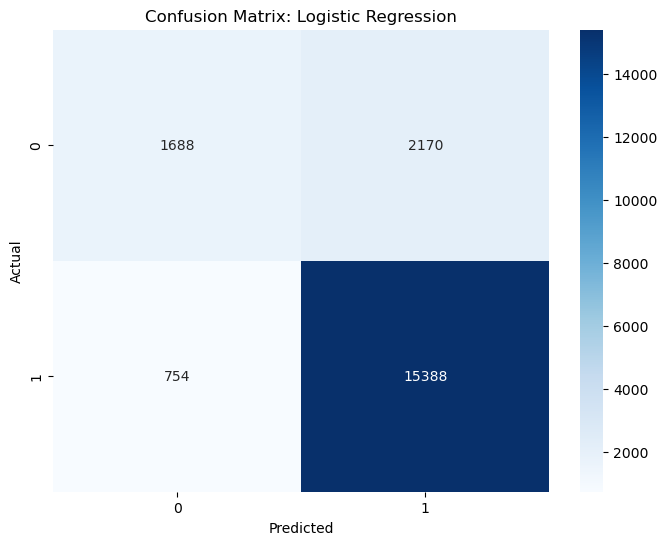

In [25]:
# Using only TF-IDF values for classification
bin_class_tfidf = classification(
    df=reviews_tfidf, 
    target="sentiment", 
    include_tfidf=True, # Include all TF-IDF columns
    show_confusion_matrix=True
)

*Runtime: 1m 3.8s*

In this case, the logistic regression performed the best, with around 85.4% accuracy in predicting review sentiment. It looks like most of our accuracy came from correctly identifying reviews with positive sentiment.

### Non TF-IDF Features

Now, lets try to run a prediction using only `vote`, `verified`, and `product_id` as our features:

In [26]:
# Using 'vote','verified', and 'product_id' features for classification
bin_class_three_features = classification(
    df=reviews_tfidf,
    target="sentiment",
    selected_features=['vote','verified','product_id'],
    include_tfidf=False
)

BEST MODEL: Logistic Regression

Performance Metrics:
Accuracy: 0.8071
Precision: 0.8071
Recall: 1.0000
F1 Score: 0.8933


*Runtime: 16.2s*

When using only 'vote', 'verified', and 'product_id', our model performance drops to around 80% prediction accuracy - meaning the inclusion of our TF-IDF embeddings is likely crucial to boosting model performance

### All Features

Next, I'll test out the models using the three features above plus our TF-IDF values:

In [27]:
# Using all features
bin_class_all_features = classification(
    df=reviews_tfidf,
    target="sentiment",
    selected_features=['vote','verified','product_id'],
    include_tfidf=True
)

BEST MODEL: Logistic Regression

Performance Metrics:
Accuracy: 0.8547
Precision: 0.8756
Recall: 0.9558
F1 Score: 0.9139


*Runtime: 1m 54.3s*

Not much of an improvement compared to our prediction using only TF-IDF. The inclusion of our other features only slightly improved our prediction accuracy. 

## Multi-Class Prediction

Let's move forward now to predicting the rating for each review using our predefined pipeline. The only difference here is that I set the "target" parameter to `rating`, which tells our pipline to run multi-class predictions. Here we go!

### TF-IDF Features Only

BEST MODEL: SVM

Performance Metrics:
Accuracy: 0.5093
Precision (Multi): 0.3096
Recall (Multi): 0.2678
F1 Score (Multi): 0.2692

Confusion Matrix:


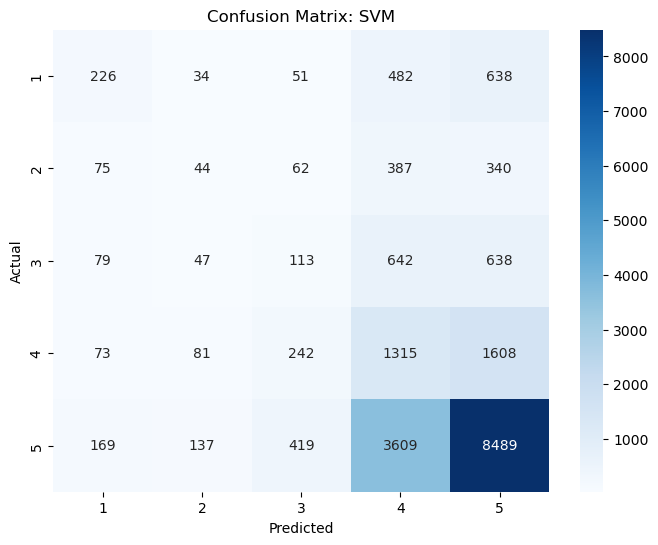

In [20]:
# Using only TF-IDF values for classification
mult_class_tfidf = classification(
    df=reviews_tfidf, 
    target="rating", 
    include_tfidf=True, # Include all TF-IDF columns
    show_confusion_matrix=True
)

*Runtime: 7m 9.5s*

Unfortunately, it looks like our multi-class model trained on only TF-IDF features does not perform as well as the binary classifier - with only 50% accuracy in correct rating assignments. When looking at the confusion matrix, it appears that the model did the best at correcly identifying 5-star reviews. This result should not be surprising, given the disproportionately large amount of 5 star reviews in the data. 

### Non TF-IDF Features

For our next iteration, let's train the multi-class model on only the non TF-IDF features to see if that changes anything:

BEST MODEL: SVM

Performance Metrics:
Accuracy: 0.6202
Precision (Multi): 0.2184
Recall (Multi): 0.2029
F1 Score (Multi): 0.1732

Confusion Matrix:


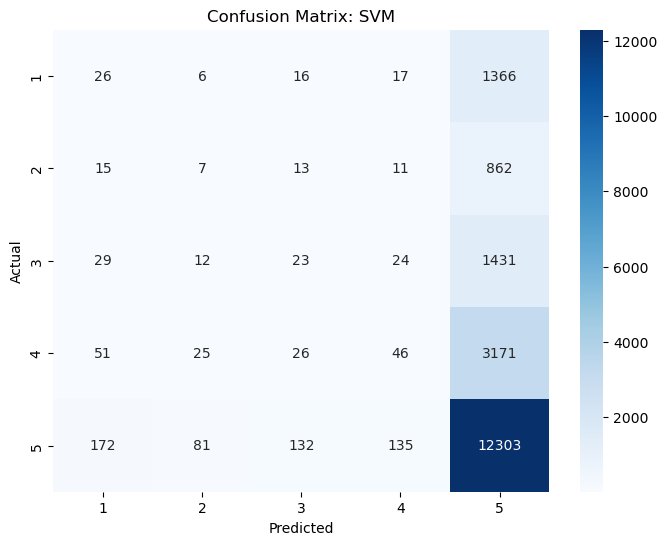

In [28]:
# Predicting rating using only vote, verified, and product_id
mult_class_three_features = classification(
    df=reviews_tfidf, 
    target="rating",
    selected_features=['vote','verified','product_id'], 
    include_tfidf=False, 
    show_confusion_matrix=True
)

*Runtime: 54.4s*

When using only the non TF-IDF features (`product_id`, `vote`, `verified`), our model's performance increases to around 62% accuracy. Still a far cry away from our binary class performance. 

### All Features

Finally, let's try to run a prediction using all of our features:

BEST MODEL: Naive Bayes

Performance Metrics:
Accuracy: 0.6485
Precision (Multi): 0.4263
Recall (Multi): 0.2663
F1 Score (Multi): 0.2694

Confusion Matrix:


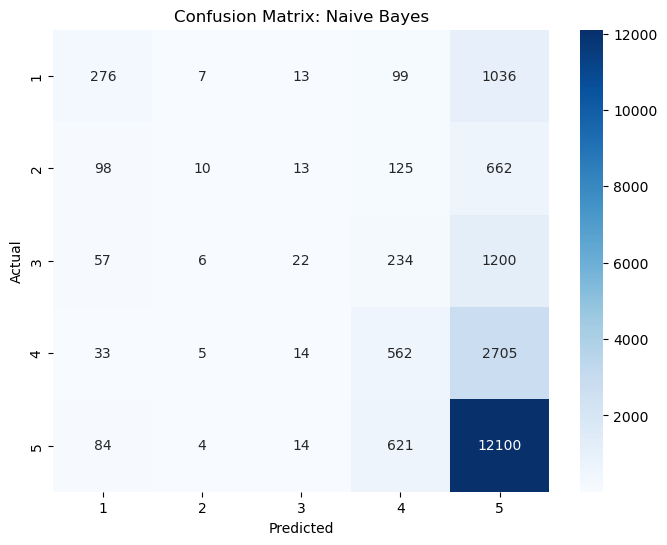

In [33]:
# Predicting rating using all features
mult_class_all_features = classification(
    df=reviews_tfidf, 
    target="rating",
    selected_features=['vote','verified','product_id'], 
    include_tfidf=True, 
    show_confusion_matrix=True
)

*Runtime: *

Our full feature model slightly outperforms the other two, with around 65% accuracy. While an improvement, the results still leave more to be desired. In all three of our multi-class predictions, the model achieves most of its accuracy from correctly classifying 5-star ratings. In all other cases, the models consistently fall flat in properly classifying lower star reviews. To try and correct this, I will try the undersampling technique outlined in Magdelano et al.[@Magdelano2024] In this method, we create a new dataframe called `reviews_tfidf_undersampled`, in which the counts of our five review classes are equal (i.e. 20% 1-star, 20% 2-star, etc.) The goal here is to provide our multi-class model with a balanced number of each target class.

## Multi-Class Prediction with Undersampling

Let's first check the counts of each rating in the data:

In [34]:
reviews_tfidf['rating'].value_counts()

rating
5    64002
4    16802
3     7691
1     6902
2     4603
Name: count, dtype: int64

It looks like our minimum value is for 1-star ratings, making up only 4603 reviews. With that in mind, let's create a new dataframe `reviews_tfidf_undersampled` where the value count for each rating class is this number.

In [32]:
# Setting minimum count
min_count = reviews_tfidf['rating'].value_counts().min()

# Create an undersampled data frame
reviews_tfidf_undersamlped = (
    # Here, we are grouping by 'rating' and randomly sampling 4603 observations from each group
    reviews_tfidf.groupby('rating').apply(lambda x: x.sample(n=min_count, random_state=5000)).reset_index(drop=True)
)

# Printing new counts
reviews_tfidf_undersamlped['rating'].value_counts()

rating
1    4603
2    4603
3    4603
4    4603
5    4603
Name: count, dtype: int64

As a quick check to see if this solves our proble - let's run the full feature model above, but this time we will use our undersampled data set

### All Features, Unsampled

Running multi-class prediction, using all features and undersampled  data set:

BEST MODEL: Naive Bayes

Performance Metrics:
Accuracy: 0.4063
Precision (Multi): 0.3975
Recall (Multi): 0.4070
F1 Score (Multi): 0.3992

Confusion Matrix:


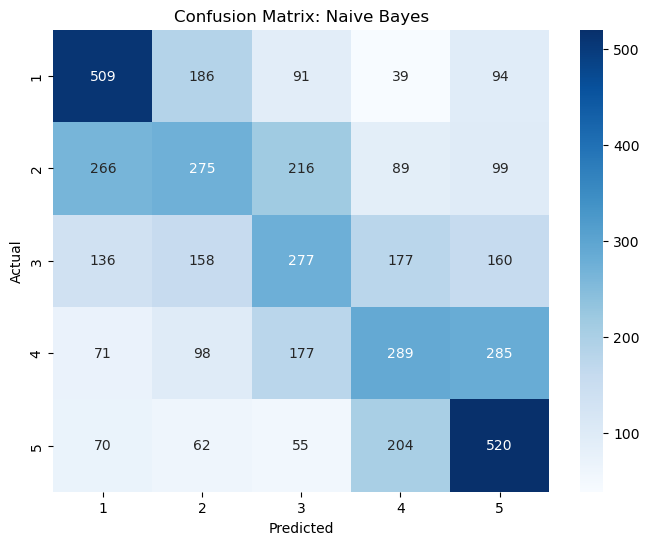

In [35]:
# Predicting rating using all features
mult_class_all_features_undersampled = classification(
    df=reviews_tfidf_undersamlped, 
    target="rating",
    selected_features=['vote','verified','product_id'], 
    include_tfidf=True, 
    show_confusion_matrix=True
)

*Runtime: 1m 26.4s*

Not the result we were looking for. Like I stated above, in prior models it looked like most of the prediction accuracy came from properly identifying 5 star reviews. However, when we used an undersampled data set, we set the proportion of those reviews equal to all of the others. 

In other words, I was able to solve the problem of our model overly focusing on the dominant 5-star class, but this came at the expense of overall accuracy (now only 40%). An interesting point to note is that for all cases when we used undersampling, the SVM model performed the best. Post-undersampling however, the Multinomial Naive Bayes model emerged as the best model - likely because its probabilistic approach to class labeling worked better when our distribution of different ratings was equal.

On a more positive note, our the confusion matrix from the undersample prediction showed improved performance in predicting the previously underrepresented classes (especially 1-stars), which were previously overshadowed by the majority 5-star class in our old data set. 

In [38]:
reviews_tfidf.head(1)

,product_id,rating,vote,verified,sentiment,text_clean,summary_clean,text,summary,polarity,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,27766,5,1,0,1,youre looking cinema k capabilities budget cam...,filmmakers love camera,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,0.321675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219799,0.0


# Section 3: Regression

**Model Selection**

**Modeling Pipeline**

**Ridge Regression**

**Random Forest Regressor**


## Model Selection

### Linear Regression
***Predicting Review Polarity***

#### Ridge Regression

- **Overview**

The ridge regression is variant of the traditional [linear regression](https://en.wikipedia.org/wiki/Linear_regression) that is specifically designed to handle cases when features are highly correlated. In traditional linear regressions, the model fits the data using the [least squares](https://en.wikipedia.org/wiki/Least_squares) approach, whereing the resulting best fit line minimizes the amount of noise in the data. The ridge regression works in a similar way, but instead of just minimizing noise, ridge regressions use a form of constrained optimization that takes the traditional least squares error and applies a regularization term $\lambda$ that works by puninshing larger coefficient values, effectively reducing multicolinearity in the data.[@Ridge]

**Linear Regression RSS:** $RSS \ = \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^2$

**Ridge Regression RSS:**[@Ridge] $RSS \ = \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^2 + \lambda \sum_{j=1}^{p} \beta_{j}^2$

- **Model Rationale**

In the context of predicting polarity using our data, I elect to use a ridge regression because our TF-IDF matrix contains embeddings from very short and repetitive documents. By that, I mean our collection of Amazon reviews are all very short and have a great deal of frequently repeated terms, which runs the risk of their respective TF-IDF values being highly correlated. Like I said before, ridge regressions work to reduce this multicolinearity.

#### Random Forest Regression

- **Overview**





# Summary

## Classification 

### Binary Classification 

- Logistic regression outperformed Random Forest in all modeling scenarios
- Highest prediction accuracy (85.47%) came from using all features

### Multi-class Classification

- MNB model had highest overall accuracy in predicting rating score (64.85%) - when all features were included from full data set
- Most of the accuracy from our multi-class predictions came from properly identifying the dominant review class (5)
- When using undersampling to correct for unbalanced classes, accuracy plummeted to 40%
- Undersampling did however allow the models to perform better in predicting previously underrepresented classes

### Challenges

- **Confusion Matrix Redundancy**

Old confusion matrix code had me running the best model again to extract predictions, so I instead opted to use a `predictions` dictionary, that stores the results for each model allowing me to reference them down the line when building the confusion matrix (without running the best model twice).

- **SVM Execution Time**

When running multi-class classification, my initial run-times were over 3 hours each. I was able to hone in on the problem being SVM, and its difficulty with handling larger datasets or when it tries to use non-linear transformations (like the radius basis function).

**Config 1:** ```SVC(kernel="rbf", probability=True) #with Unscaled features```
- In this configuration, I used the radial basis function (RBF) kernel for transformations
- *Runtime: > 3 hours*

**Config 2:** ```SVC(kernel="linear", probability=True) #with Unscaled features```
- For the second config, I changed the kernel to "linear", for [faster](https://scikit-learn.org/1.5/modules/svm.html) performance
- *Runtime: > 3 hours*

**Config 3:** ```SVC(kernel="linear", probability=True) #with MinMaxScaled features```
- Here, I tried scaling the features using sklearn's [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to reduce complexity of TF-IDF values
- *Runtime: > 3 hours*

**Config 5:** ``` SVC(kernel='rbf',C=0.5,gamma ='auto',tol=0.01,shrinking=False,max_iter=1000,cache_size=1000,probability=False) #with MinMaxScaled features```
- At this point, I consulted OpenAI's ChatGPT-4o model to help create the fastest SVM configuration.[@gpt4o_SVM]
